Breast Cancer Detection using DenseNet201 Transfer Learning

This script implements a deep learning model for breast cancer detection using histopathological images.
The model classifies images as either benign or malignant using transfer learning with DenseNet201.
Each step is clearly documented for educational purposes.

> Author: Pouryare

> Date: 2024-10-24

In [1]:
import os
from typing import Tuple, List, Optional
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
def load_and_preprocess_image(
    image_path: str,
    target_size: Tuple[int, int] = (224, 224)
) -> Optional[np.ndarray]:
    """
    Load and preprocess a single image.

    Args:
        image_path: Path to the image file
        target_size: Desired size for the output image

    Returns:
        Preprocessed image as numpy array
    """
    try:
        with Image.open(image_path) as img:
            # Convert to RGB and resize
            img = img.convert('RGB')
            img = img.resize(target_size, Image.LANCZOS)
            # Convert to numpy array and normalize
            img_array = np.array(img, dtype=np.float32) / 255.0
            return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [3]:
def load_dataset(
    directory: str,
    target_size: Tuple[int, int] = (224, 224)
) -> np.ndarray:
    """
    Load and preprocess images from the specified directory.

    Args:
        directory: Path to the image directory
        target_size: Desired size for the output images

    Returns:
        Array of preprocessed images
    """
    images = []
    for image_name in tqdm(os.listdir(directory)):
        if image_name.lower().endswith('.png'):
            image_path = os.path.join(directory, image_name)
            img_array = load_and_preprocess_image(image_path, target_size)
            if img_array is not None:
                images.append(img_array)

    return np.stack(images)

In [4]:
def visualize_samples(
    X: np.ndarray,
    y: np.ndarray,
    samples: int = 12,
    title: str = "Sample Images"
) -> None:
    """
    Visualize sample images from the dataset with their labels.

    Args:
        X: Image data
        y: Labels (one-hot encoded)
        samples: Number of samples to display
        title: Title for the plot
    """
    plt.figure(figsize=(15, 15))
    for i in range(samples):
        plt.subplot(samples // 4 + 1, 4, i + 1)
        plt.imshow(X[i])
        plt.title('Benign' if np.argmax(y[i]) == 0 else 'Malignant')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_class_distribution(y: np.ndarray) -> None:
    """
    Plot the distribution of classes in the dataset.

    Args:
        y: Labels (one-hot encoded)
    """
    class_counts = np.sum(y, axis=0)
    plt.figure(figsize=(8, 6))
    plt.bar(['Benign', 'Malignant'], class_counts)
    plt.title('Class Distribution in Dataset')
    plt.ylabel('Number of Images')
    plt.grid(True, alpha=0.3)
    plt.show()

In [6]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Plot confusion matrix.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [7]:
def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """
    Plot training and validation metrics.

    Args:
        history: Training history from model.fit
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
def build_model(input_shape: Tuple[int, int, int] = (224, 224, 3)) -> tf.keras.Model:
    """
    Build and compile the DenseNet201-based model.

    Args:
        input_shape: Input image dimensions

    Returns:
        Compiled Keras model
    """
    # Create input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Load DenseNet201 base
    base_model = DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
# 1. Set paths and load data
print("Step 1: Loading and preprocessing data...")
BENIGN_PATH = '/content/drive/MyDrive/ML/Breast cancer detection/Dataset/benign'
MALIGN_PATH = '/content/drive/MyDrive/ML/Breast cancer detection/Dataset/malign'

Step 1: Loading and preprocessing data...


In [10]:
# Load benign images
print("\nLoading benign images...")
benign_images = load_dataset(BENIGN_PATH)
print(f"Loaded {len(benign_images)} benign images with shape {benign_images.shape}")


Loading benign images...


100%|██████████| 112/112 [00:45<00:00,  2.46it/s]

Loaded 112 benign images with shape (112, 224, 224, 3)


In [11]:
# Load malignant images
print("\nLoading malignant images...")
malign_images = load_dataset(MALIGN_PATH)
print(f"Loaded {len(malign_images)} malignant images with shape {malign_images.shape}")


Loading malignant images...


100%|██████████| 127/127 [01:16<00:00,  1.66it/s]

Loaded 127 malignant images with shape (127, 224, 224, 3)


In [12]:
# 2. Create labels and combine datasets
print("\nStep 2: Preparing labels and combining datasets...")
benign_labels = np.zeros(len(benign_images))
malign_labels = np.ones(len(malign_images))

X = np.concatenate((benign_images, malign_images), axis=0)
y = np.concatenate((benign_labels, malign_labels), axis=0)


Step 2: Preparing labels and combining datasets...


In [13]:
# 3. Shuffle data
print("\nStep 3: Shuffling data...")
np.random.seed(42)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


Step 3: Shuffling data...


In [14]:
# Convert labels to categorical
y = to_categorical(y, num_classes=2)

In [15]:
# 4. Split data
print("\nStep 4: Splitting data into train and validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Step 4: Splitting data into train and validation sets...
Training set shape: (191, 224, 224, 3)
Validation set shape: (48, 224, 224, 3)



Step 5: Visualizing data samples...


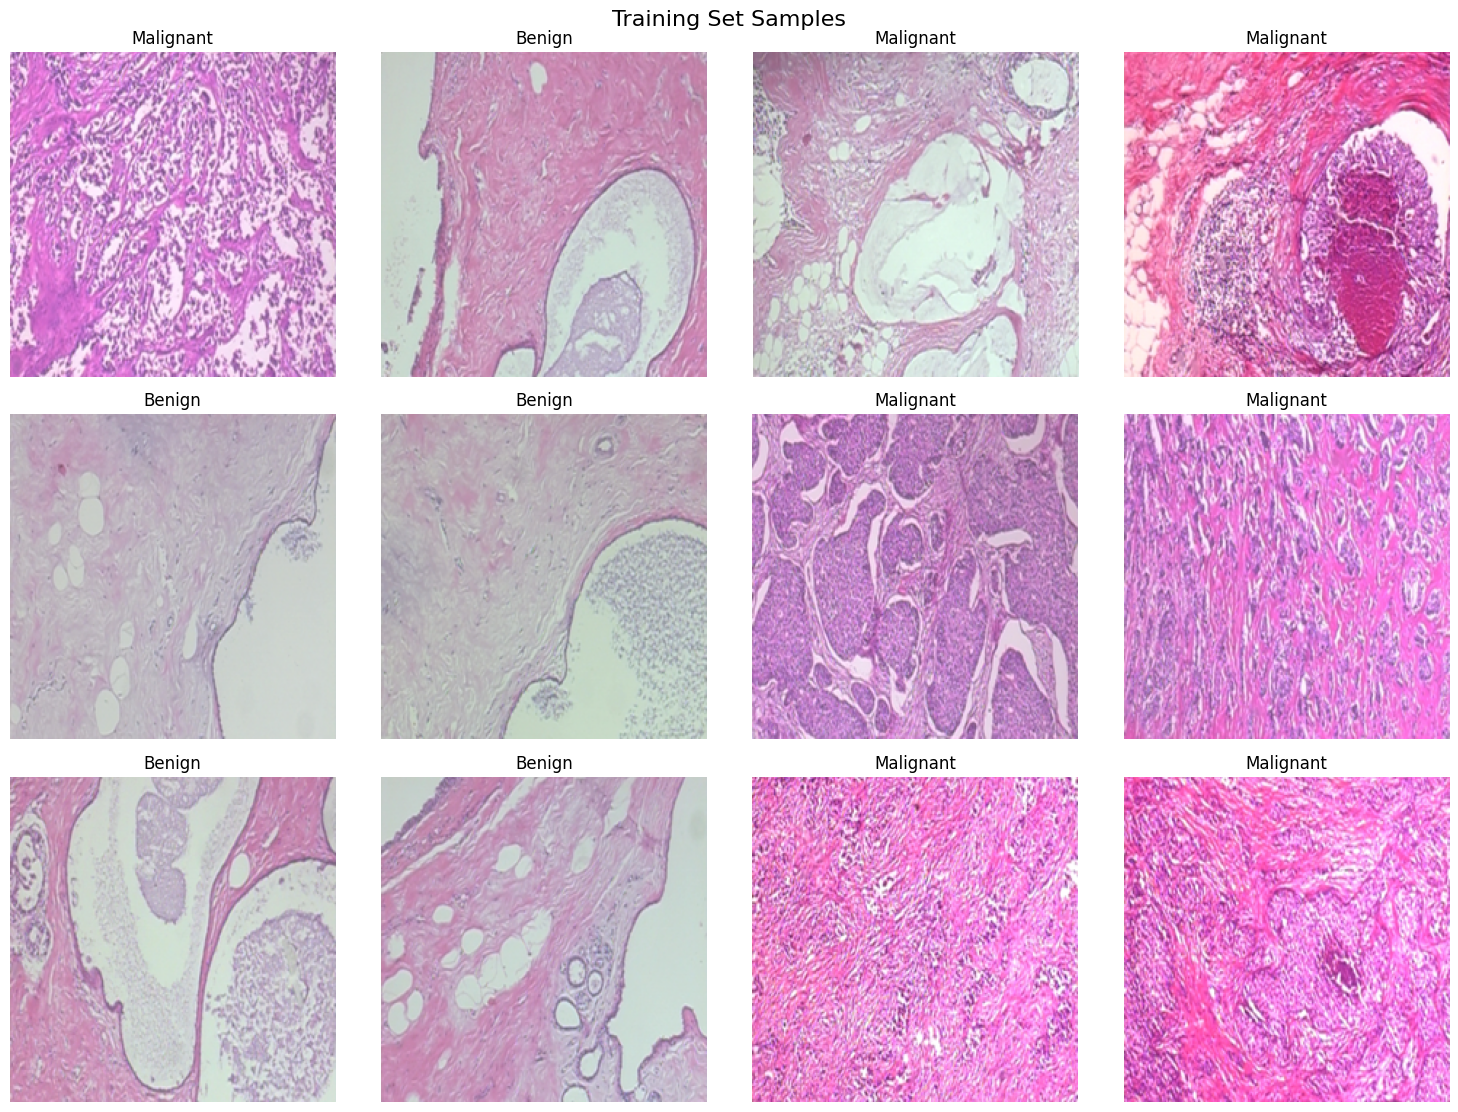

In [16]:
# 5. Visualize data
print("\nStep 5: Visualizing data samples...")
visualize_samples(X_train, y_train, title="Training Set Samples")

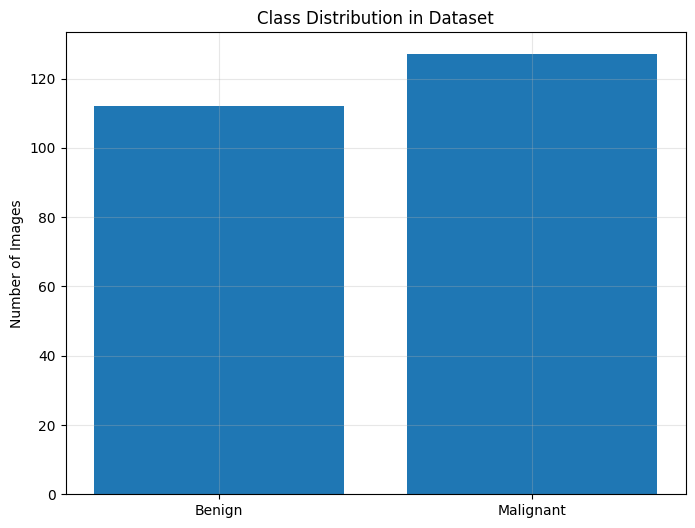

In [17]:
plot_class_distribution(y)

In [18]:
# 6. Create data generator for augmentation
print("\nStep 6: Setting up data augmentation...")
train_generator = ImageDataGenerator(
    rotation_range=20,  # Reduced from 90
    zoom_range=0.1,    # Reduced from 0.2
    horizontal_flip=True,
    vertical_flip=False
)


Step 6: Setting up data augmentation...


In [19]:
# 7. Build model
print("\nStep 7: Building and compiling model...")
model = build_model()
model.summary()


Step 7: Building and compiling model...
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 18,333,506 (69.94 MB)

 Trainable params: 7,682 (30.01 KB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [20]:
# 8. Setup training parameters
print("\nStep 8: Setting up training parameters...")
BATCH_SIZE = 4
EPOCHS = 50


Step 8: Setting up training parameters...


In [21]:
# Create callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=1e-7
)

In [22]:
# 9. Train initial model
print("\nStep 9: Training initial model...")
history = model.fit(
    train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)


Step 9: Training initial model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.5116 - loss: 0.7704 - val_accuracy: 0.5000 - val_loss: 0.7070 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5168 - loss: 0.7606 - val_accuracy: 0.5833 - val_loss: 0.6985 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4895 - loss: 0.7596 - val_accuracy: 0.5625 - val_loss: 0.6899 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5735 - loss: 0.7078 - val_accuracy: 0.6250 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5700 - loss: 0.7123 - val_accuracy: 0.6667 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5564 - loss: 0.7172 - val_accuracy: 0.6875 - val_loss: 0.6513 - learning_rate: 1.0000e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5890 - loss: 0.70


Step 10: Plotting training history...


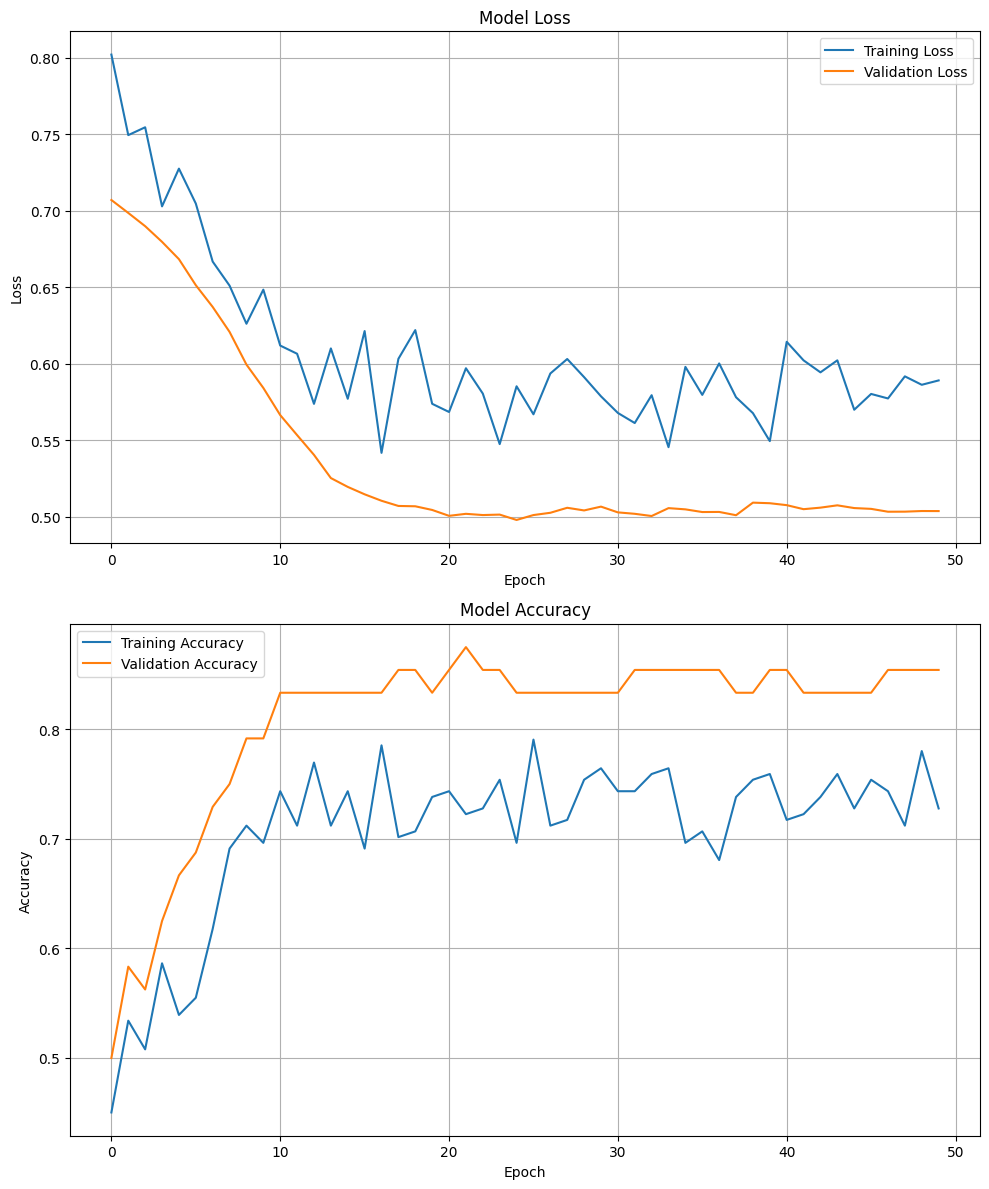

In [23]:
# 10. Plot training history
print("\nStep 10: Plotting training history...")
plot_training_history(history)


Step 12: Evaluating model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 14s/step

Classification Report:
              precision    recall  f1-score   support

      Benign       0.83      0.86      0.84        22
   Malignant       0.88      0.85      0.86        26

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.86      0.85      0.85        48


Confusion Matrix:


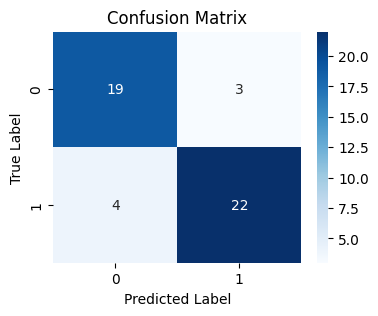

In [24]:
# 11. Evaluate model
print("\nStep 12: Evaluating model...")
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=['Benign', 'Malignant']))

print("\nConfusion Matrix:")
plot_confusion_matrix(y_true_classes, y_pred_classes)

In [25]:
# 12. Save model and training history
print("\nStep 13: Saving model and training history...")
model.save('/content/drive/MyDrive/ML/Breast cancer detection/breast_cancer_model.keras')
joblib.dump(history.history,
           '/content/drive/MyDrive/ML/Breast cancer detection/training_history.joblib')
print("Model and training history saved successfully!")

print("\nComplete! The model is ready for use.")


Step 13: Saving model and training history...
Model and training history saved successfully!

Complete! The model is ready for use.
